In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [26]:
def check_NaN(data):
    # Select only numeric columns for spline interpolation
    numeric_columns = data.select_dtypes(include=[np.number]).columns

    print("Number of NaN values:\n", data[numeric_columns].isna().sum())
    
def count_missing_coumns_by_month(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['YearMonth'] = df ['Date'].dt.to_period('M')
    
    missing_counts = df.groupby('YearMonth')[columns].apply(lambda x: x.isnull().sum())
    
    missing_counts = missing_counts[(missing_counts > 0).any(axis=1)]
    
    print("Number of missing values by month and yr where any column is null:")
    print(missing_counts)
    
def exact_missing_date(df, column):
    if column not in df.columns:
        print(f"Column {column} does not exist in the dataframe.")
        return
    
    null_dates = df[df[column].isna()]["Date"].unique()
    
    if len(null_dates) == 0:
        print(f"No missing dates found in column {column}.")
    else:
        print(f"Missing values for {column} are in the following dates:")
        for date in null_dates:
            print(date)

# Fetch Data

`actual_data` has the entire excel file <br>
`data` has the data from `2017-01-01 00:00` till `2024-08-20 23:00`

In [28]:
actual_data = pd.read_excel("../../DATAFORMODELtrain200824.xlsx")
# Convert 'Date' to datetime format
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%m/%d/%Y %H:%M').dt.round('h')

In [36]:
start_date = pd.to_datetime('2017-01-01 00:00')
cutoff_date = pd.to_datetime("2024-08-20 23:00")

In [37]:
data = actual_data[(actual_data['Date'] >= start_date) & (actual_data['Date'] <= cutoff_date)]

In [38]:
exact_missing_date(data, 'PriceCZ')

Missing values for PriceCZ are in the following dates:
2017-03-26 02:00:00
2018-03-25 02:00:00
2019-03-31 02:00:00
2021-03-28 02:00:00
2022-03-27 02:00:00
2023-03-26 02:00:00
2024-03-31 02:00:00


In [58]:
data.head()

,Date,Y,M,Day,H,PriceHU,PriceSK,PriceRO,PriceCZ,PMIHU,GAS,COAL,CO2,COALTOGAS,WDAY,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023,Y2024,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL
8784,2017-01-01 00:00:00,2017,1,1,1,57.25,18.5,57.25,18.5,52.2,18.75,90.1,4.59,4.805333,0,1,1,1,1,-6.320000,0.596667,-6.566667,-3.920000,-9.267900,8.680000,39.8412,6536.04,-1.751667,-5.518333,137.5929,11.73,-7.27,0.0,2.95,0.0,99.0025,9.95,-6.05,0.0,2.47,0.0,235.9296,15.36,-5.64,0.0,3.19,0.0,0.0,218.0,87.0,305.0,0.0,0.0,0.0,0.0,0.0,0,1037.0,2511.0,3658.0,361,470,847,2169.0,3560.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,2102.0,5554.0,8310.0,361.0,753.0,394.0,2595.0,15315.0,0.0,0.0,0.0,508,0,20,528,600.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,794.227921,536.354837,2835.148013,0.0,0.0,-1.839444,426.0,0,831,0,0.0,0.0,2843.042154,12019,11973,8126.0
8785,2017-01-01 01:00:00,2017,1,1,2,50.21,13.0,50.21,13.0,52.2,18.75,90.1,4.59,4.805333,0,1,1,1,1,-6.420000,0.596667,-6.566667,-3.972778,-9.320678,8.580000,39.3822,6323.46,-1.816667,-5.603333,134.0964,11.58,-7.42,0.0,3.06,0.0,102.6169,10.13,-5.87,0.0,2.17,0.0,225.9009,15.03,-5.97,0.0,3.20,0.0,0.0,287.0,87.0,374.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1625.0,2000.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,789.0,4380.0,5959.0,361.0,737.0,451.0,2661.0,15447.0,0.0,0.0,0.0,508,0,20,528,497.0,50,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,768.212097,529.276572,2776.036637,0.0,0.0,-1.867778,426.0,0,831,0,0.0,0.0,2824.859846,12143,11973,5639.0
8786,2017-01-01 02:00:00,2017,1,1,3,44.04,16.0,44.04,16.0,52.2,18.75,90.1,4.59,4.805333,0,1,1,1,1,-6.380000,0.596667,-6.566667,-4.000556,-9.348456,8.620000,39.5658,5197.86,-1.894167,-5.635833,131.5609,11.47,-7.53,0.0,3.10,0.0,111.3025,10.55,-5.45,0.0,1.71,0.0,220.2256,14.84,-6.16,0.0,3.28,0.0,0.0,218.0,87.0,305.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1631.0,2006.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,720.0,4386.0,5896.0,361.0,603.0,316.0,2657.0,15341.0,0.0,0.0,0.0,519,0,20,539,474.0,50,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,742.385124,523.365848,2724.866331,0.0,0.0,-1.878611,426.0,0,831,0,0.0,0.0,2807.029700,12044,11973,5576.0
8787,2017-01-01 03:00:00,2017,1,1,4,32.81,16.4,32.81,16.4,52.2,18.75,90.1,4.59,4.805333,0,1,1,1,1,-6.346667,0.596667,-6.566667,-4.007500,-9.355400,8.653333,39.7188,4387.24,-1.970833,-5.659167,129.2769,11.37,-7.63,0.0,3.08,0.0,114.9184,10.72,-5.28,0.0,1.26,0.0,221.1169,14.87,-6.13,0.0,3.39,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1631.0,2006.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,720.0,4299.0,5809.0,361.0,507.0,344.0,2608.0,14854.0,0.0,0.0,0.0,519,0,20,539,509.0,50,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,717.719032,518.821337,2683.314660,0.0,0.0,-1.886389,426.0,0,831,0,0.0,0.0,2789.870447,11559,11973,5489.0
8788,2017-01-01 04:00:00,2017,1,1,5,28.41,16.0,

In [39]:
check_NaN(data)

Number of NaN values:
 Y               0
M               0
Day             0
H               0
PriceHU         0
PriceSK         0
PriceRO         0
PriceCZ         7
PMIHU           0
GAS             0
COAL            0
CO2             0
COALTOGAS       0
WDAY            0
DOFFHU          0
DOFFSK          0
DOFFRO          0
WND             0
T2MALL          0
T2MALLMAX       0
T2MALLMIN       0
T2MALLAV        0
T2MALLNONLIN    0
T2MALLP         0
T2MALLPCO2      0
T2MALLPROR      0
T2MHUNORM       0
THUDEVNORM      0
T2MHUPSQ        0
T2MHUP          0
T2MHU           0
PRECHU          0
WS10MHU         0
ALLSKY1HU       0
T2MSKPSQ        0
T2MSKP          0
T2MSK           0
PRECSK          0
WS10MSK         0
ALLSKY1SK       0
T2MROPSQ        0
T2MROP          0
T2MRO           0
PRECRO          0
WS10MRO         0
ALLSKY1RO       0
UNAVNUCHU       0
UNAVGASHU       0
UNAVLIGNHU      0
UNAVTPPHU       0
UNAVNUCSK       0
UNAVGASSK       0
UNAVLIGNSK      0
UNAVTPPSK       0
UNAVH

In [40]:
# Ensure you are working with the original DataFrame using .loc
target_column = 'PriceCZ'  # Replace with the specific column you want to fill

# Identify missing values in the target column
missing_dates = data[data[target_column].isna()]['Date']

# Perform spline interpolation to fill missing values, using .loc to modify the DataFrame in place
data.loc[:, target_column] = data[target_column].interpolate(method='linear')

# Print missing dates with their new interpolated values and one value before and after
print("Interpolated values with context:")
for missing_date in missing_dates:
    # Find the index of the missing date
    idx = data.index[data['Date'] == missing_date].tolist()[0]
    
    # Get the row before, the missing date row, and the row after
    start_idx = max(0, idx - 1)  # Ensure the start index is not less than 0
    end_idx = min(len(data), idx + 2)  # Ensure the end index does not exceed the length
    
    # Get the relevant rows
    rows_to_print = data.iloc[start_idx:end_idx]

    # Print the details
    print(rows_to_print[['Date', target_column]])
    print("\n")  # Just to separate each block for readability

Interpolated values with context:
                     Date  PriceCZ
19585 2018-03-27 01:00:00    41.03
19586 2018-03-27 02:00:00    41.00
19587 2018-03-27 03:00:00    39.50


                     Date  PriceCZ
28321 2019-03-26 01:00:00    30.88
28322 2019-03-26 02:00:00    29.90
28323 2019-03-26 03:00:00    29.46


                     Date  PriceCZ
37225 2020-03-31 01:00:00    22.95
37226 2020-03-31 02:00:00    23.20
37227 2020-03-31 03:00:00    23.80


                     Date  PriceCZ
54697 2022-03-29 01:00:00   210.18
54698 2022-03-29 02:00:00   208.96
54699 2022-03-29 03:00:00   210.00


                     Date  PriceCZ
63433 2023-03-28 01:00:00    87.02
63434 2023-03-28 02:00:00    85.68
63435 2023-03-28 03:00:00    86.02


                     Date  PriceCZ
72169 2024-03-26 01:00:00    73.30
72170 2024-03-26 02:00:00    70.11
72171 2024-03-26 03:00:00    69.04


Empty DataFrame
Columns: [Date, PriceCZ]
Index: []




# Features against Temporal Features

In [97]:
# Define temporal features with both options
single_hour_feature = ['H']  # Single column for hour representation
single_year_feature = ['Y']
single_month_feature = ['M']
# Define temporal features with one-hot encoding for years, months, and hours
one_hot_year_features = [f'Y{year}' for year in range(2017, 2025)]  # One-hot encoded year columns (Y2017 to Y2024)
one_hot_month_features = [f'M{month}' for month in range(1, 13)]  # One-hot encoded month columns (M1 to M12)
one_hot_hour_features = [f'h{i}' for i in range(1, 25)]  # One-hot encoded hour columns (h1 to h24)

## Co Relation Calculations

### **Column Definitions:**

- **Y2017 to Y2024**: One-hot encoded columns indicating the respective year.
- **M1 to M12**: One-hot encoded columns indicating the respective month (January to December).
- **h1 to h24**: One-hot encoded columns indicating the respective hour of the day (1 AM to midnight).
- **Y**: Numerical representation of the year.
- **M**: Numerical representation of the month.
- **Day**: Numerical representation of the day of the month.
- **H**: Numerical representation of the hour of the day (1 to 24).
- **WDay**: Work day repersentation with `1` for true and `0` for false

### W/o 1 hot encoding

In [106]:
# Choose the representation: Uncomment one of the two options below
temporal_features = ['Day', 'WDAY'] + single_hour_feature + single_month_feature + single_year_feature # Option 1: Use single column 'H'

In [107]:
# Ensure temporal features are in your dataset
available_temporal_features = [feature for feature in temporal_features if feature in data.columns]
# Remove one-hot encoded hour columns when using 'H'
columns_to_exclude = {'Date'}.union(one_hot_hour_features).union(one_hot_month_features).union(one_hot_year_features)
# Calculate the correlation of each non-temporal feature with the temporal features
non_temporal_features = set(data.columns) - set(available_temporal_features) - columns_to_exclude

# Calculate the correlation of each non-temporal feature with the temporal features
feature_correlations = {}

In [108]:
# Calculate the combined correlation of each feature with the temporal features
for feature in non_temporal_features:
    combined_correlation = 0
    for temporal in available_temporal_features:
        # Compute absolute correlation
        correlation = abs(data[[temporal, feature]].corr().iloc[0, 1])
        combined_correlation += correlation
    
    feature_correlations[feature] = combined_correlation

# Sort the features by their combined correlation in descending order
sorted_features = sorted(feature_correlations.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 features most affected by temporal features
top_10_features_simple = sorted_features[:10]

print("Top 10 features without 1 hot encoding:")
for i, (feature, corr) in enumerate(top_10_features_simple, 1):
    print(f"{i}. Feature: {feature}, Combined Correlation: {corr}")

Top 10 features without 1 hot encoding:
1. Feature: UNAVTPPRO, Combined Correlation: 1.0380461319760803
2. Feature: UNAVHYDRALL, Combined Correlation: 0.8810191973174382
3. Feature: RORSE, Combined Correlation: 0.8422615749853475
4. Feature: UNAVLIGNSL, Combined Correlation: 0.8342749150694966
5. Feature: UNAVTPPSL, Combined Correlation: 0.8332062894407151
6. Feature: UNAVGASRO, Combined Correlation: 0.8258696741935221
7. Feature: UNAVHYDRBG, Combined Correlation: 0.7947162839174573
8. Feature: UA_EU, Combined Correlation: 0.7870429319224446
9. Feature: UNAVHYDRRO, Combined Correlation: 0.7820464777497407
10. Feature: PriceHU, Combined Correlation: 0.770749074378467


### Using 1 Hot Encoding for Hour

In [109]:
temporal_features = ['Y', 'M', 'Day', 'WDAY'] + one_hot_hour_features  # Option 2: Use one-hot encoding for hours
# Ensure temporal features are in your dataset
available_temporal_features = [feature for feature in temporal_features if feature in data.columns]

In [110]:
# Calculate the correlation of each non-temporal feature with the temporal features
feature_correlations = {}
non_temporal_features = set(data.columns) - set(available_temporal_features) - {'Date', 'H'}


In [111]:
# Calculate the combined correlation of each feature with the temporal features
for feature in non_temporal_features:
    combined_correlation = 0
    for temporal in available_temporal_features:
        # Compute absolute correlation
        correlation = abs(data[[temporal, feature]].corr().iloc[0, 1])
        combined_correlation += correlation
    
    feature_correlations[feature] = combined_correlation

# Sort the features by their combined correlation in descending order
sorted_features = sorted(feature_correlations.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 features most affected by temporal features
top_10_features_one_hot = sorted_features[:10]

print("Top 10 features using 1 hot encoding for H:")
for i, (feature, corr) in enumerate(top_10_features_one_hot, 1):
    print(f"{i}. Feature: {feature}, Combined Correlation: {corr}")

Top 10 features using 1 hot encoding for H:
1. Feature: ROSOLGEN, Combined Correlation: 3.80858300158649
2. Feature: RHBSOLGEN, Combined Correlation: 3.5050804948410064
3. Feature: RHSOLGEN, Combined Correlation: 3.4236091358107736
4. Feature: BGSOLGEN, Combined Correlation: 3.365008019906775
5. Feature: HUSOLGEN, Combined Correlation: 2.884184825215467
6. Feature: ALLSKY1RO, Combined Correlation: 2.830047978678208
7. Feature: ALLSKY1HU, Combined Correlation: 2.702026244278489
8. Feature: ALLSKY1SK, Combined Correlation: 2.615241250753267
9. Feature: RORSE, Combined Correlation: 2.442308437706192
10. Feature: T2MROPSQ, Combined Correlation: 1.9644302169693564


### Using 1 hot encoding for all

In [112]:
# Combine all temporal features
temporal_features = one_hot_year_features + one_hot_month_features + one_hot_hour_features + ['WDAY', 'Day']  # Include workday indicator

# Ensure temporal features are in your dataset
available_temporal_features = [feature for feature in temporal_features if feature in data.columns]

# Remove any non-temporal columns such as 'PriceHU' and 'Date'
columns_to_exclude = {'Date', 'H', 'Y', 'M'}

# Calculate the correlation of each non-temporal feature with the temporal features
non_temporal_features = set(data.columns) - set(available_temporal_features) - columns_to_exclude

In [113]:
# Calculate the combined correlation of each feature with the temporal features
feature_correlations = {}
for feature in non_temporal_features:
    combined_correlation = 0
    # print(f"\nCalculating correlations for feature: {feature}")
    for temporal in available_temporal_features:
        # Compute absolute correlation and handle NaN values
        correlation = abs(data[[temporal, feature]].corr().iloc[0, 1])
        # print(f"Correlation between {temporal} and {feature}: {correlation}")
        if pd.isna(correlation):  # Check if the correlation is NaN
            correlation = 0  # Treat NaN correlations as zero to include them
        combined_correlation += correlation
    
    feature_correlations[feature] = combined_correlation

# Sort the features by their combined correlation in descending order
sorted_features = sorted(feature_correlations.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 features most affected by temporal features
top_10_features_1_hot_all = sorted_features[:20]

print("\nTop 10 features using 1 hot encoding for all Y M H:")
for i, (feature, corr) in enumerate(top_10_features_1_hot_all, 1):
    print(f"{i}. Feature: {feature}, Combined Correlation: {corr}")


Top 10 features using 1 hot encoding for all Y M H:
1. Feature: ROSOLGEN, Combined Correlation: 4.829483902128278
2. Feature: RHBSOLGEN, Combined Correlation: 4.779787108132275
3. Feature: RHSOLGEN, Combined Correlation: 4.721961528522786
4. Feature: T2MROPSQ, Combined Correlation: 4.595632458328276
5. Feature: BGSOLGEN, Combined Correlation: 4.595441941043605
6. Feature: T2MRO, Combined Correlation: 4.562174274961233
7. Feature: T2MROP, Combined Correlation: 4.562174274961209
8. Feature: T2MALL, Combined Correlation: 4.513720737768945
9. Feature: T2MALLP, Combined Correlation: 4.513720737768934
10. Feature: T2MHUNORM, Combined Correlation: 4.491693487331811
11. Feature: T2MHUPSQ, Combined Correlation: 4.441671490403842
12. Feature: T2MSKPSQ, Combined Correlation: 4.4049579452401835
13. Feature: T2MHU, Combined Correlation: 4.4014528724295445
14. Feature: T2MHUP, Combined Correlation: 4.401452872429544
15. Feature: RORSE, Combined Correlation: 4.37607026400873
16. Feature: T2MSKP, Com

### All temporal features

In [114]:
# Combine all temporal features
temporal_features = one_hot_year_features + one_hot_month_features + one_hot_hour_features + ['WDAY', 'Day'] + single_hour_feature + single_month_feature + single_year_feature # Include workday indicator

# Ensure temporal features are in your dataset
available_temporal_features = [feature for feature in temporal_features if feature in data.columns]

# Remove any non-temporal columns such as 'PriceHU' and 'Date'
columns_to_exclude = {'Date'}

# Calculate the correlation of each non-temporal feature with the temporal features
non_temporal_features = set(data.columns) - set(available_temporal_features) - columns_to_exclude

In [115]:
# Calculate the combined correlation of each feature with the temporal features
feature_correlations = {}
for feature in non_temporal_features:
    combined_correlation = 0
    # print(f"\nCalculating correlations for feature: {feature}")
    for temporal in available_temporal_features:
        # Compute absolute correlation and handle NaN values
        correlation = abs(data[[temporal, feature]].corr().iloc[0, 1])
        # print(f"Correlation between {temporal} and {feature}: {correlation}")
        if pd.isna(correlation):  # Check if the correlation is NaN
            correlation = 0  # Treat NaN correlations as zero to include them
        combined_correlation += correlation
    
    feature_correlations[feature] = combined_correlation

# Sort the features by their combined correlation in descending order
sorted_features = sorted(feature_correlations.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 features most affected by temporal features
top_10_features_1_all = sorted_features[:20]

print("\nTop 10 features using 1 hot encoding for all Y M H:")
for i, (feature, corr) in enumerate(top_10_features_1_all, 1):
    print(f"{i}. Feature: {feature}, Combined Correlation: {corr}")


Top 10 features using 1 hot encoding for all Y M H:
1. Feature: T2MALLPCO2, Combined Correlation: 5.246580137073988
2. Feature: RHBSOLGEN, Combined Correlation: 5.154033422777993
3. Feature: RORSE, Combined Correlation: 5.1536065929453905
4. Feature: RHSOLGEN, Combined Correlation: 5.136917164608437
5. Feature: T2MROPSQ, Combined Correlation: 5.042270544362447
6. Feature: T2MRO, Combined Correlation: 5.030386384137161
7. Feature: T2MROP, Combined Correlation: 5.030386384137131
8. Feature: ROSOLGEN, Combined Correlation: 4.961423521388986
9. Feature: T2MALL, Combined Correlation: 4.9254698644513155
10. Feature: T2MALLP, Combined Correlation: 4.925469864451298
11. Feature: BGSOLGEN, Combined Correlation: 4.865735720678487
12. Feature: T2MHUNORM, Combined Correlation: 4.840873037512807
13. Feature: T2MHUPSQ, Combined Correlation: 4.789633501262789
14. Feature: T2MHUP, Combined Correlation: 4.771480437077138
15. Feature: T2MHU, Combined Correlation: 4.771480437077134
16. Feature: T2MSKPSQ

## Visualizing Results

In [117]:
# Define the start and end datetime in the specified format
start_datetime = '2018-01-01 00:00:00'
end_datetime = '2019-01-1 00:00:00'  # You can adjust the end date as needed

# Convert start and end datetime to pandas datetime format
start_datetime = pd.to_datetime(start_datetime)
end_datetime = pd.to_datetime(end_datetime)

### no 1 hot encoding results visualized

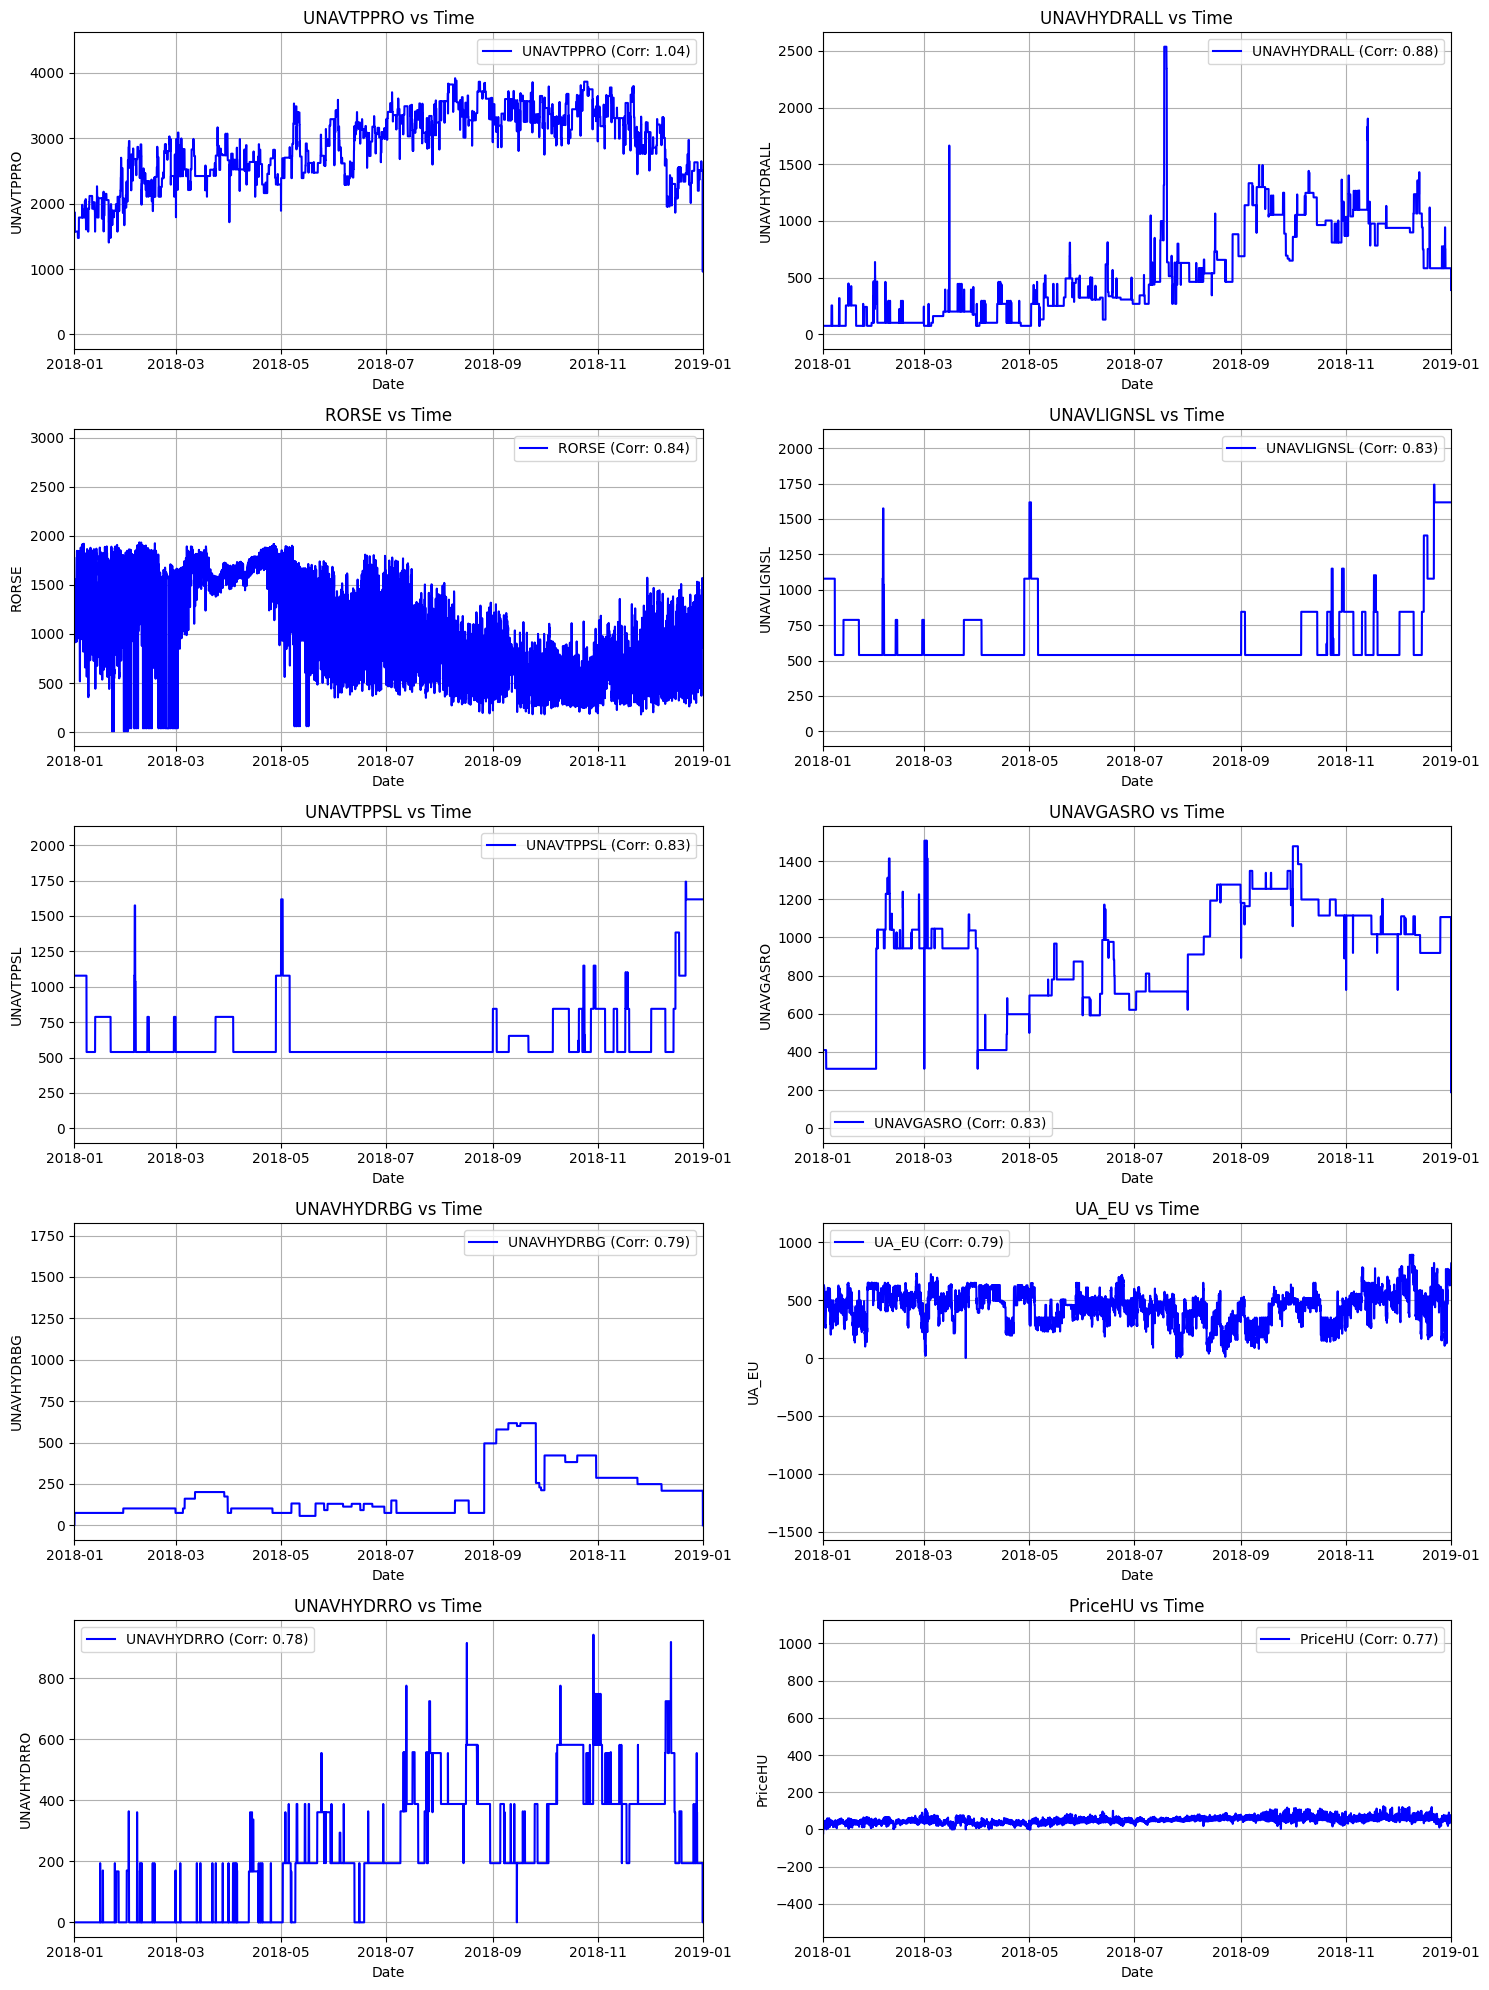

In [122]:
# Create a plot for each of the top 10 features against time within the date range
plt.figure(figsize=(15, 20))  # Set the figure size for better readability

# Loop through the top 10 features and create a subplot for each
for i, (feature, corr) in enumerate(top_10_features_simple, 1):
    plt.subplot(5, 2, i)  # Create a subplot grid with 5 rows and 2 columns
    plt.plot(data['Date'], data[feature], label=f'{feature} (Corr: {corr:.2f})', color='b')

    # Apply the filtering using the start and end datetime directly in the plot function
    plt.xlim(start_datetime, end_datetime)  # Set x-axis limits to filter data within the range
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} vs Time')
    plt.grid(True)
    plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### 1 hot encoding for H results visualized

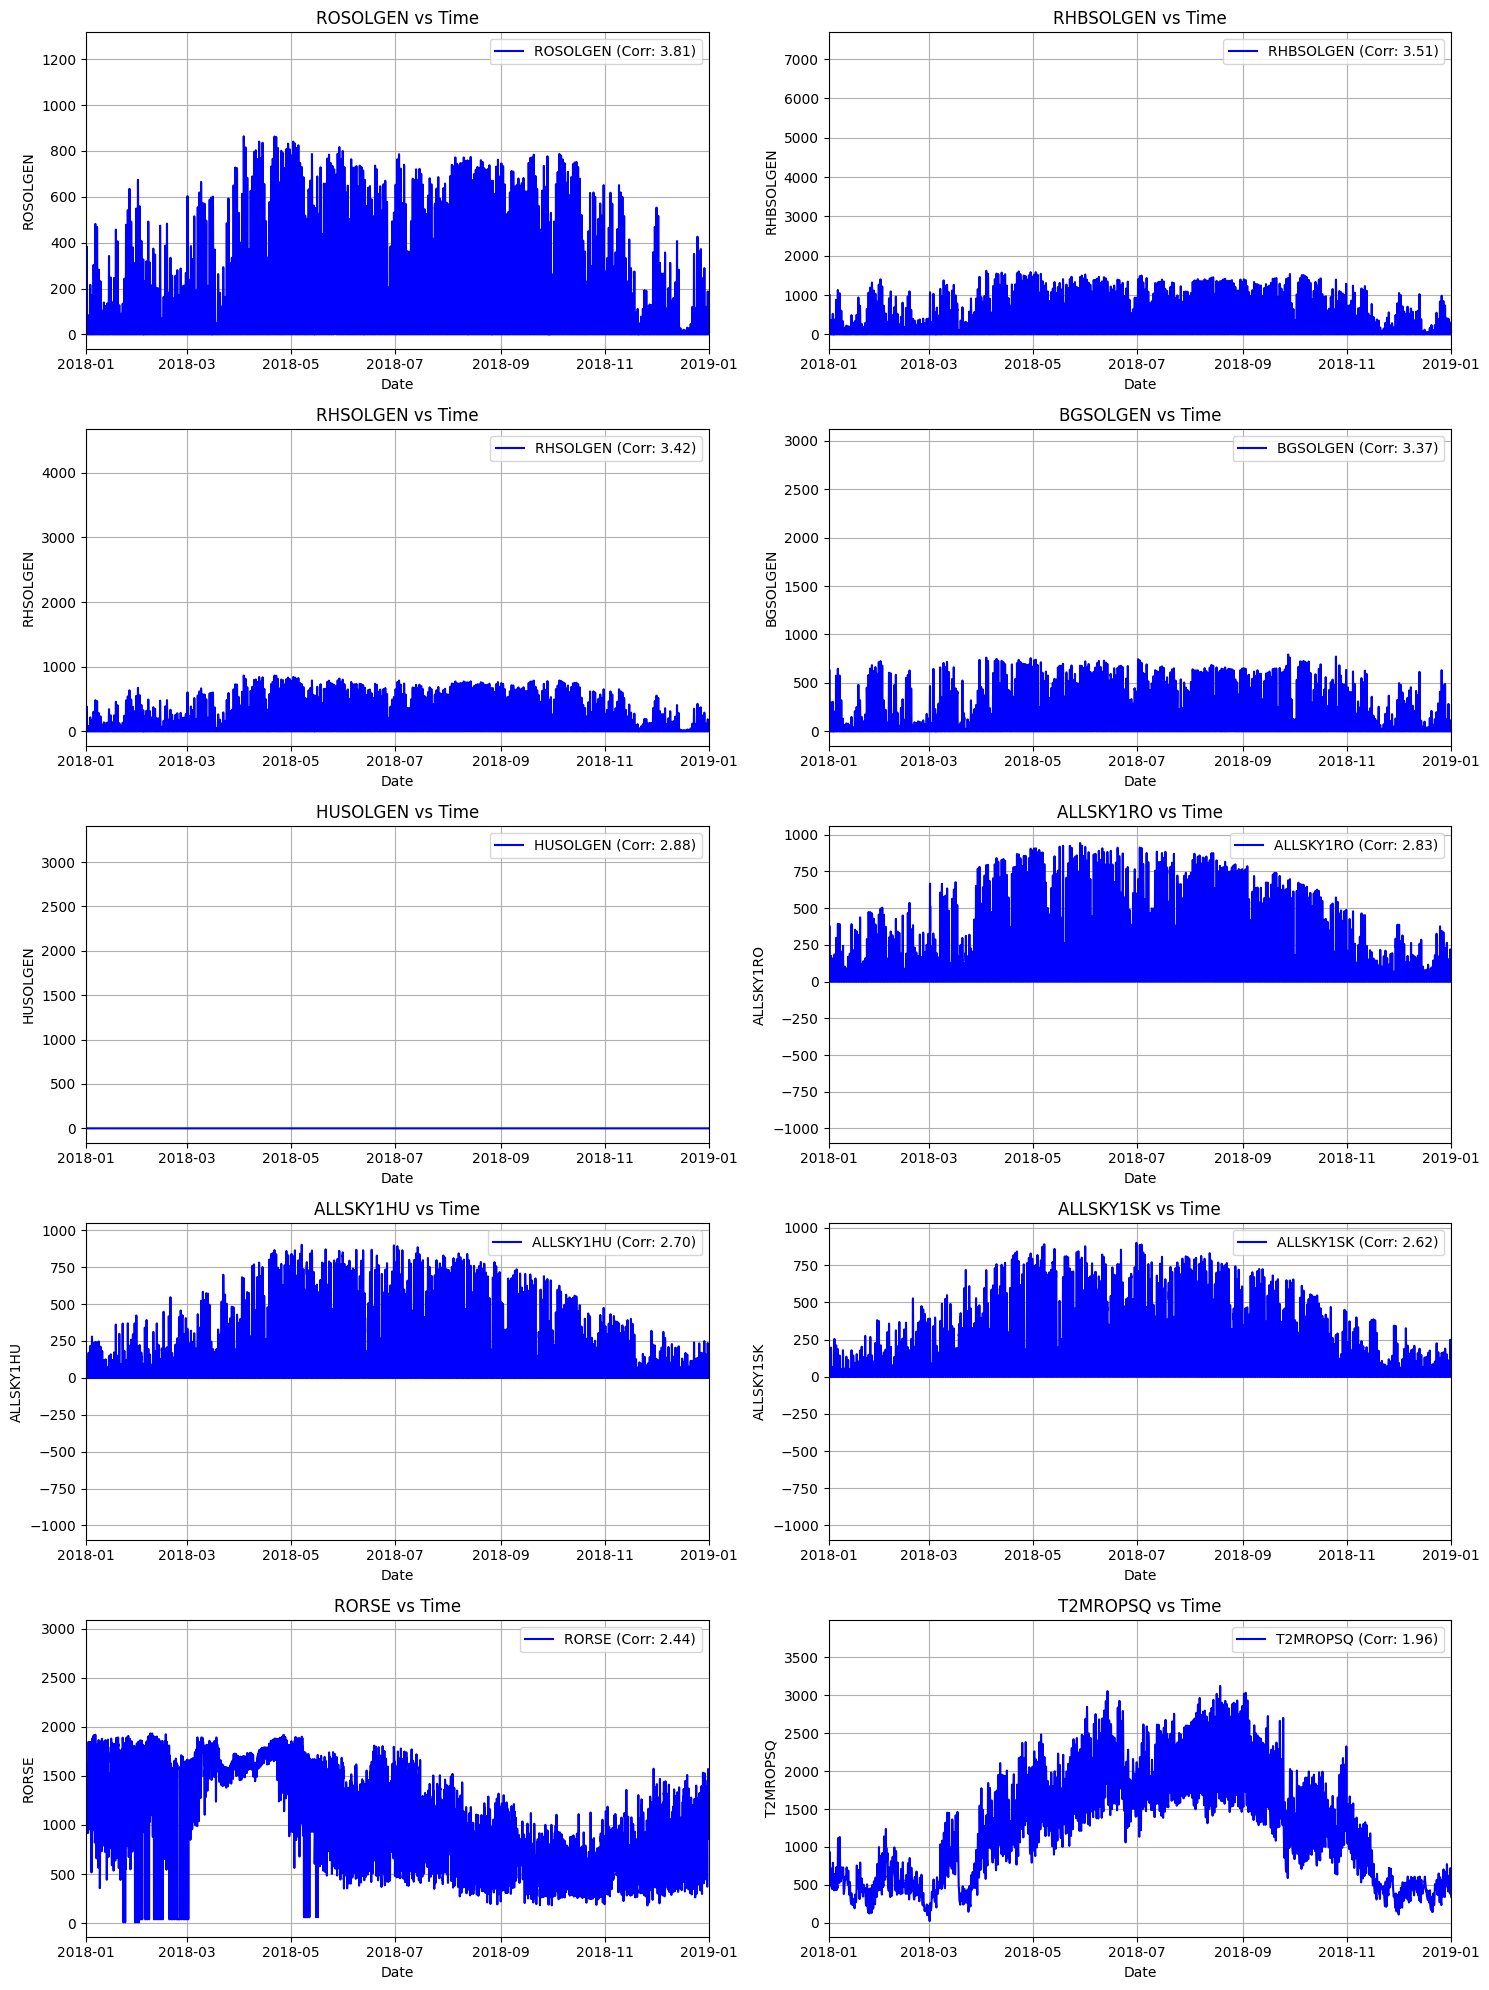

In [121]:
# Create a plot for each of the top 10 features against time within the date range
plt.figure(figsize=(15, 20))  # Set the figure size for better readability

# Loop through the top 10 features and create a subplot for each
for i, (feature, corr) in enumerate(top_10_features_one_hot, 1):
    plt.subplot(5, 2, i)  # Create a subplot grid with 5 rows and 2 columns
    plt.plot(data['Date'], data[feature], label=f'{feature} (Corr: {corr:.2f})', color='b')

    # Apply the filtering using the start and end datetime directly in the plot function
    plt.xlim(start_datetime, end_datetime)  # Set x-axis limits to filter data within the range
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} vs Time')
    plt.grid(True)
    plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### 1 hot encoding for all results visulaized

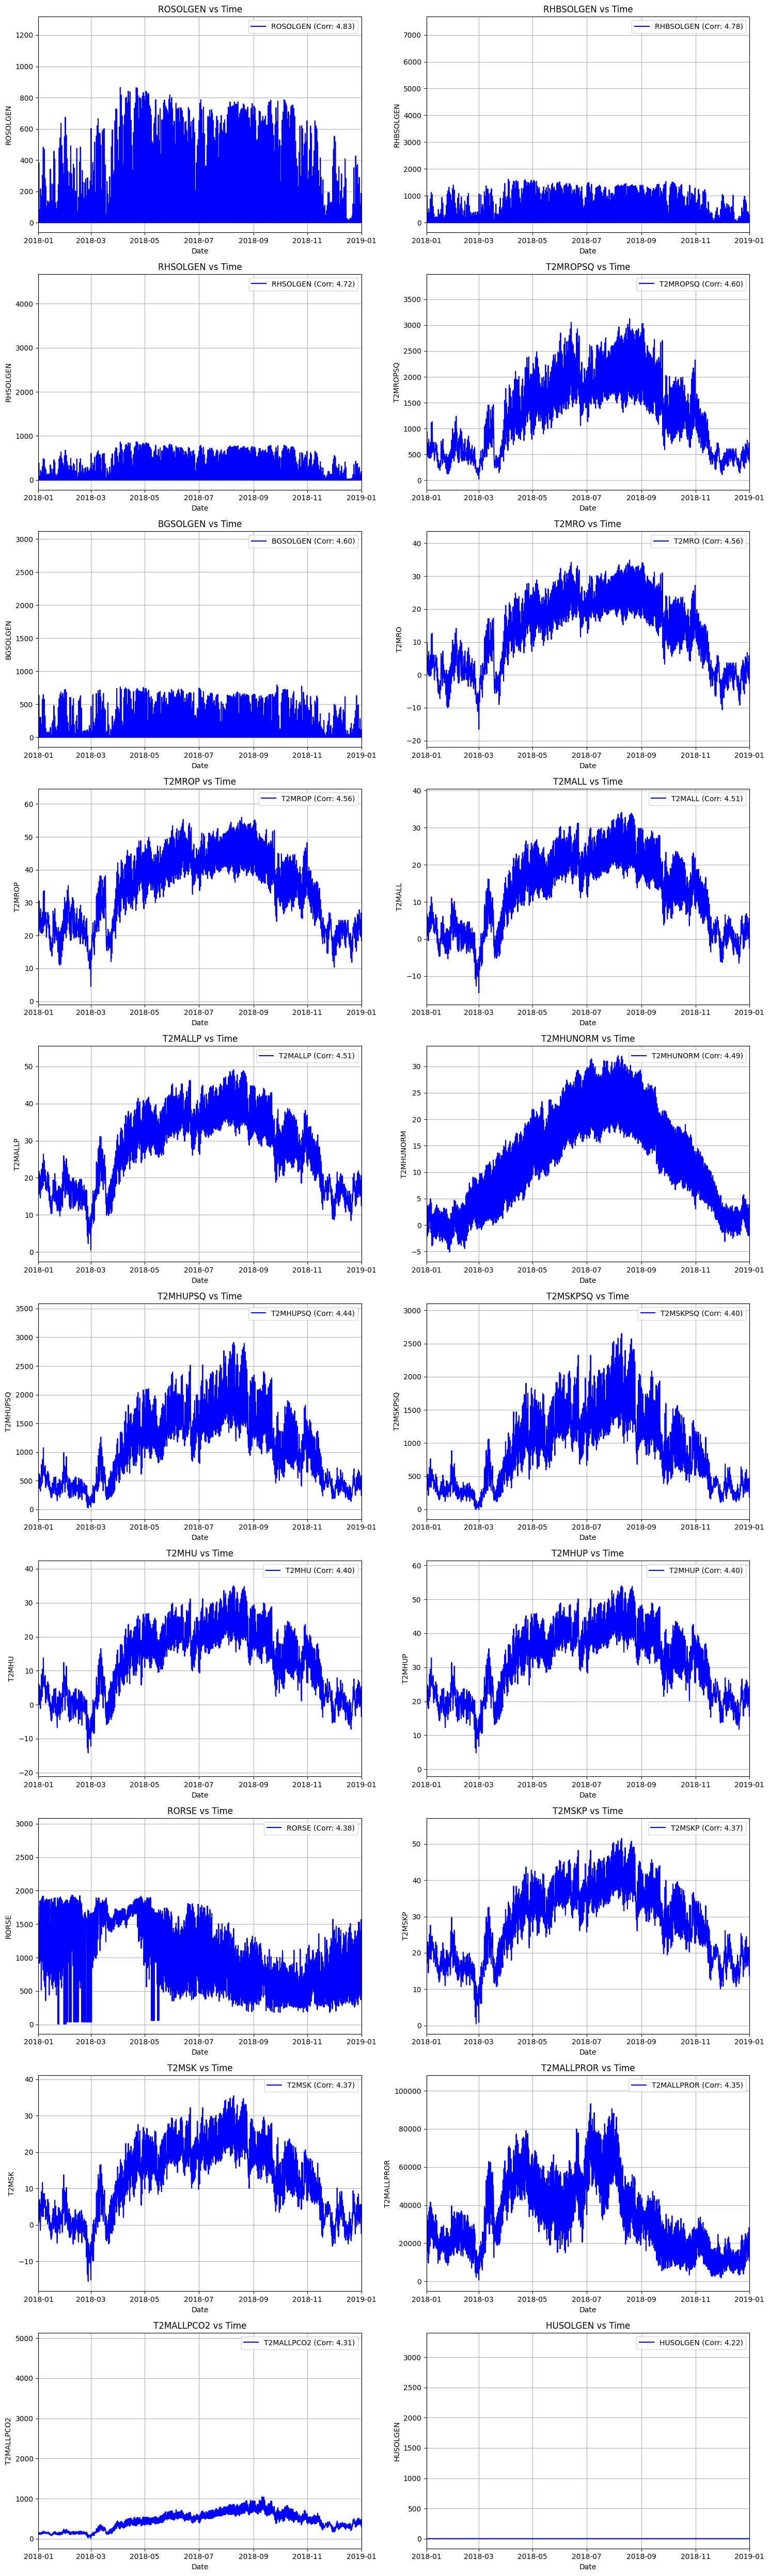

In [119]:
# Convert start and end datetime to pandas datetime format
start_datetime = pd.to_datetime(start_datetime)
end_datetime = pd.to_datetime(end_datetime)

# Calculate the number of features to plot
num_features = len(top_10_features_1_hot_all)

# Dynamically calculate the number of rows and columns for subplots
num_cols = 2  # Define number of columns for subplots
num_rows = math.ceil(num_features / num_cols)  # Calculate number of rows needed

# Create a figure for plotting
plt.figure(figsize=(15, 5 * num_rows))  # Dynamically adjust height based on the number of rows

# Loop through each feature and create a subplot for each
for i, (feature, corr) in enumerate(top_10_features_1_hot_all, 1):
    plt.subplot(num_rows, num_cols, i)  # Create a subplot dynamically
    plt.plot(data['Date'], data[feature], label=f'{feature} (Corr: {corr:.2f})', color='b')

    # Apply the filtering using the start and end datetime directly in the plot function
    plt.xlim(start_datetime, end_datetime)  # Set x-axis limits to filter data within the range
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} vs Time')
    plt.grid(True)
    plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### All temporal features including 1 hot encoding and simple column

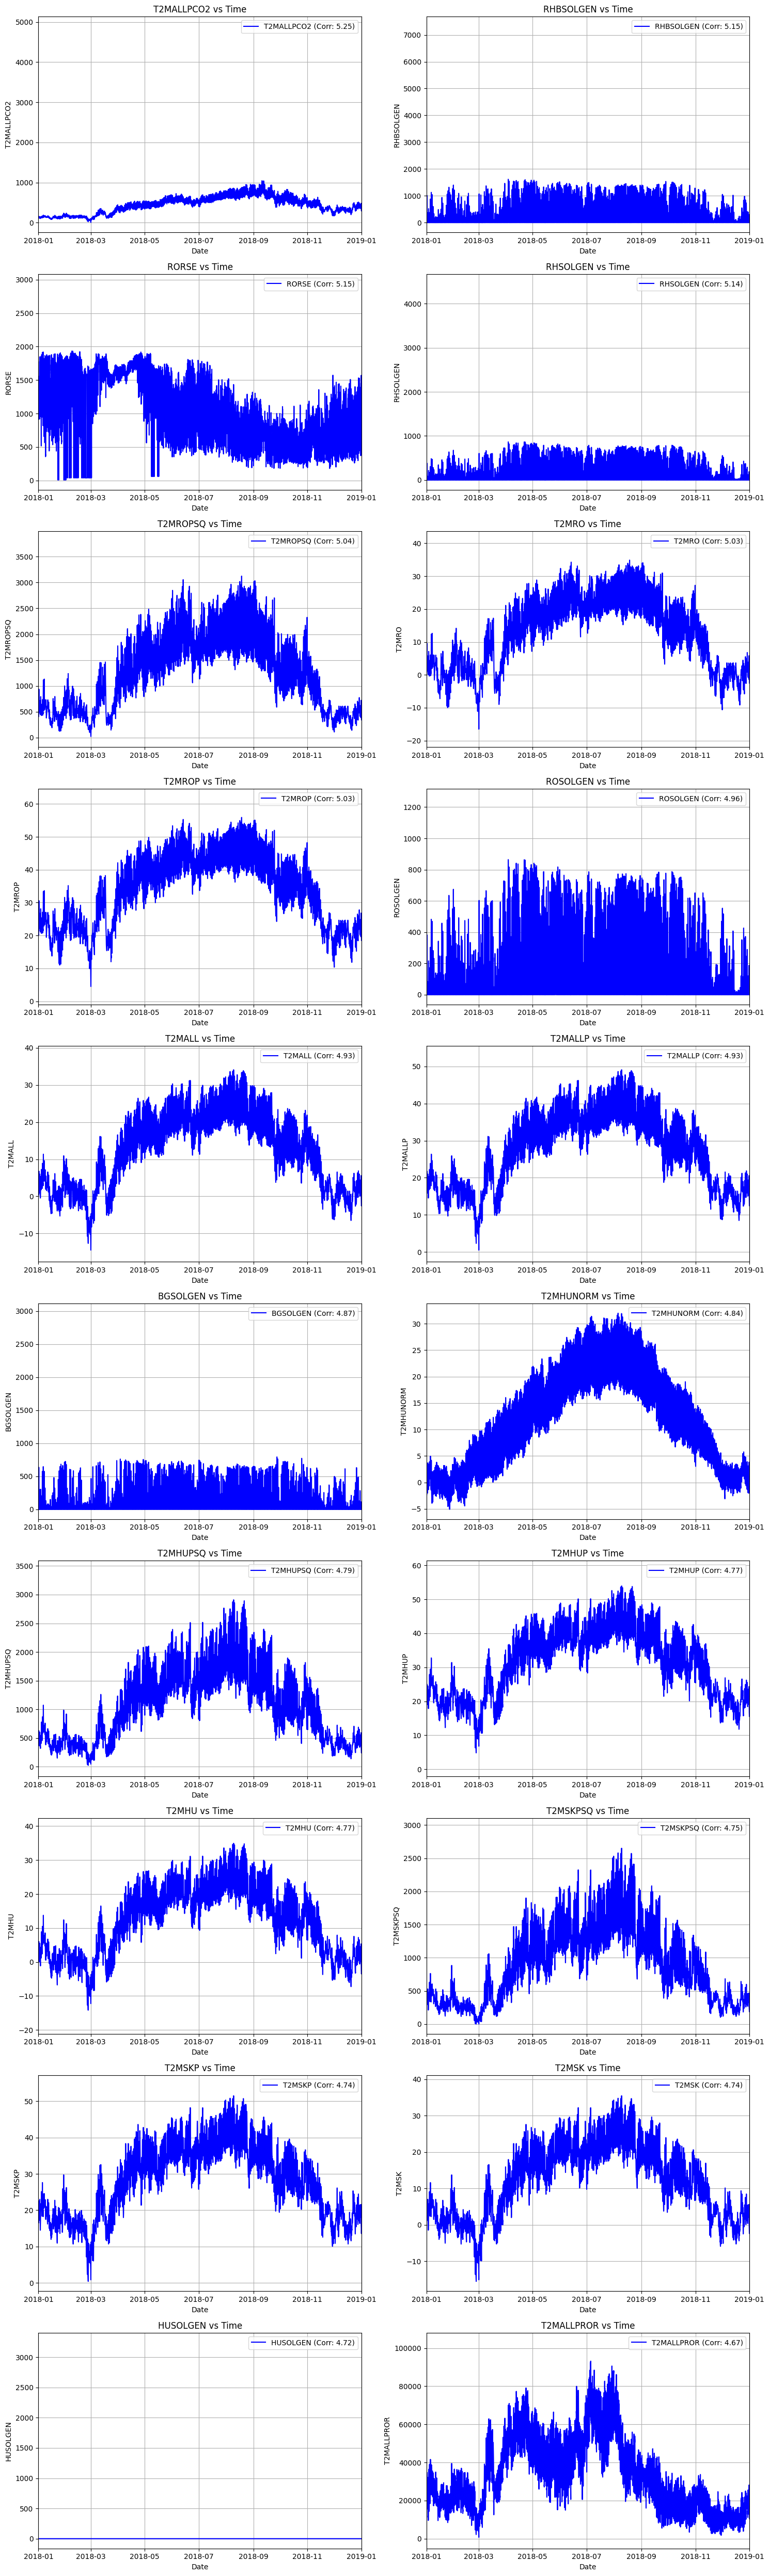

In [118]:
# Convert start and end datetime to pandas datetime format
start_datetime = pd.to_datetime(start_datetime)
end_datetime = pd.to_datetime(end_datetime)

# Calculate the number of features to plot
num_features = len(top_10_features_1_all)

# Dynamically calculate the number of rows and columns for subplots
num_cols = 2  # Define number of columns for subplots
num_rows = math.ceil(num_features / num_cols)  # Calculate number of rows needed

# Create a figure for plotting
plt.figure(figsize=(15, 5 * num_rows))  # Dynamically adjust height based on the number of rows

# Loop through each feature and create a subplot for each
for i, (feature, corr) in enumerate(top_10_features_1_all, 1):
    plt.subplot(num_rows, num_cols, i)  # Create a subplot dynamically
    plt.plot(data['Date'], data[feature], label=f'{feature} (Corr: {corr:.2f})', color='b')

    # Apply the filtering using the start and end datetime directly in the plot function
    plt.xlim(start_datetime, end_datetime)  # Set x-axis limits to filter data within the range
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} vs Time')
    plt.grid(True)
    plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()